In [1]:
%matplotlib inline
import functools
import itertools
import multiprocess as mp

import modin.pandas as pd
from tqdm.notebook import tqdm, trange
import seaborn as sns
import matplotlib.pyplot as plt

import edgedroid.data as e_data
import edgedroid.util as util
from edgedroid.execution_times import *
from mpl_toolkits import mplot3d

fade_distance = 4
raw_data_params = e_data.load_default_exec_time_data()
data = preprocess_data(*raw_data_params, transition_fade_distance=fade_distance)
raw_data, *_ = raw_data_params
data

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration
0,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)"
1,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)"
2,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)"
3,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)"
4,134146,5,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[0.0, 5.0)"
...,...,...,...,...,...,...,...
6715,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,NoTransition,"[0.0, 5.0)"
6716,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,NoTransition,"[0.0, 5.0)"
6717,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,NoTransition,"[5.0, 10.0)"
6718,137353,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,NoTransition,"[5.0, 10.0)"


In [20]:
data.groupby(["impairment", "transition", "duration"])["next_exec_time"].describe()

count      mean       std    min  \
impairment  transition   duration                                        
[-inf, 1.0) Higher2Lower [0.0, 5.0)   585.0  5.926154  2.734934  0.032   
            NoTransition [0.0, 5.0)   766.0  5.344946  2.646483  1.867   
                         [5.0, 10.0)  443.0  4.770009  2.264320  1.839   
                         [10.0, inf)  106.0  5.280104  2.930713  1.888   
[1.0, 2.0)  Higher2Lower [0.0, 5.0)   373.0  6.417748  2.966883  1.739   
            Lower2Higher [0.0, 5.0)    88.0  6.315852  3.219382  2.090   
            NoTransition [0.0, 5.0)   416.0  5.419118  2.240274  1.218   
                         [5.0, 10.0)  400.0  5.847480  3.191857  1.440   
                         [10.0, inf)  640.0  5.371858  2.401947  0.949   
[2.0, inf)  Lower2Higher [0.0, 5.0)   878.0  6.564335  3.849435  0.214   
            NoTransition [0.0, 5.0)   816.0  6.150847  3.391591  0.175   
                         [5.0, 10.0)  520.0  6.830181  4.083379  0.049   
                         [10.0, inf)  649.0  6.065586  3.556862  0.151   

                                          25%     50%      75%     max  
impairment  transition   duration                                       
[-inf, 1.0) Higher2Lower [0.0, 5.0)   4.33800  5.5420  6.89600  37.923  
            NoTransition [0.0, 5.0)   3.64625  4.8400  6.39625  29.495  
                         [5.0, 10.0)  3.21300  4.3050  5.82900  20.677  
                         [10.0, inf)  2.94900  4.6300  6.54175  16.520  
[1.0, 2.0)  Higher2Lower [0.0, 5.0)   4.65000  5.8920  7.67000  29.504  
            Lower2Higher [0.0, 5.0)   4.33450  5.8590  7.33250  26.269  
            NoTransition [0.0, 5.0)   3.79675  5.1215  6.50800  16.438  
                         [5.0, 10.0)  4.07300  5.3085  6.85525  41.629  
                         [10.0, inf)  3.78150  4.9360  6.45675  22.326  
[2.0, inf)  Lower2Higher [0.0, 5.0)   4.41075  5.8815  7.87125  56.017  
            NoTransition [0.0, 5.0)   4.17075  5.4080  7.29850  32.815  
                         [5.0, 10.0)  4.29775  6.1025  8.35025  47.330  
                         [10.0, inf)  3.97600  5.2590  7.27700  34.329

In [2]:
raw_data

,run_id,seq,exec_time,delay,neuroticism
0,134146,1,4.433,0.0,0.375
1,134146,2,2.956,0.0,0.375
2,134146,3,5.443,0.0,0.375
3,134146,4,5.206,0.0,0.375
4,134146,5,4.783,0.0,0.375
...,...,...,...,...,...
6715,137353,164,6.501,0.0,0.625
6716,137353,165,4.722,0.0,0.625
6717,137353,166,3.475,0.0,0.625
6718,137353,167,2.296,0.0,0.625


In [3]:
# generate data for model

num_traces = 100
run_ids = raw_data.run_id.unique()
run_len = len(raw_data[raw_data.run_id == np.random.choice(run_ids)].index)

with mp.Pool() as pool:
    dfs = deque()

    for model_cls in (TheoreticalExecutionTimeModel, EmpiricalExecutionTimeModel):
        model_name = model_cls.__name__

        for participant in tqdm(run_ids, desc=model_name, leave=True):
            raw_delays = raw_data[raw_data.run_id == participant].delay
            neuro = raw_data[raw_data.run_id == participant].neuroticism.values[0]

            # model = model_cls(data=data, neuroticism=neuro)
            for j, trace in enumerate(
                pool.imap(
                    lambda t: util.gen_model_trace(delays=t[0], model=t[1](data=t[2], neuroticism=t[3], transition_fade_distance=t[4])),
                    zip(
                        itertools.repeat(raw_delays, num_traces),
                        itertools.repeat(model_cls),
                        itertools.repeat(data),
                        itertools.repeat(neuro),
                        itertools.repeat(fade_distance)
                    )
                )
            ):
                trace["run_id"] = participant
                trace.index = trace.index.set_names(["step_index"])
                trace["model"] = model_name
                dfs.append(trace.reset_index())

results = pd.concat(dfs, ignore_index=True)

TheoreticalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

EmpiricalExecutionTimeModel:   0%|          | 0/40 [00:00<?, ?it/s]

In [4]:
results

,step_index,model neuroticism,model neuroticism (binned),latest impairment,latest transition,current duration,current duration (binned),exec_time,delay,run_id,model
0,0,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,0,"[0.0, 5.0)",2.946102,NaN,134146,TheoreticalExecutionTimeModel
1,1,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,1,"[0.0, 5.0)",4.467004,0.0,134146,TheoreticalExecutionTimeModel
2,2,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,2,"[0.0, 5.0)",4.880126,0.0,134146,TheoreticalExecutionTimeModel
3,3,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,3,"[0.0, 5.0)",4.714395,0.0,134146,TheoreticalExecutionTimeModel
4,4,0.375,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,4,"[0.0, 5.0)",8.475939,0.0,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...,...,...,...
1351995,164,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,4,"[0.0, 5.0)",2.750000,0.0,137353,EmpiricalExecutionTimeModel
1351996,165,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,1,"[0.0, 5.0)",4.777000,0.0,137353,EmpiricalExecutionTimeModel
1351997,166,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,2,"[0.0, 5.0)",7.328000,0.0,137353,EmpiricalExecutionTimeModel
1351998,167,0.625,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,3,"[0.0, 5.0)",3.346000,0.0,137353,EmpiricalExecutionTimeModel


In [5]:
df1 = results.drop(columns=[col for col in results.columns
                      if col not in ['step_index', 'model neuroticism (binned)',
                      'latest impairment', 'latest transition', 'run_id',
                      'current duration (binned)', 'exec_time', 'model']])\
    .rename(columns={
        'step_index': 'seq',
        'model neuroticism (binned)': 'neuroticism',
        'latest impairment': 'impairment',
        'latest transition': 'transition',
        'current duration (binned)': 'duration',
        'exec_time': 'next_exec_time'
    }
)
df1

,seq,neuroticism,impairment,transition,duration,next_exec_time,run_id,model
0,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",2.946102,134146,TheoreticalExecutionTimeModel
1,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.467004,134146,TheoreticalExecutionTimeModel
2,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.880126,134146,TheoreticalExecutionTimeModel
3,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.714395,134146,TheoreticalExecutionTimeModel
4,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",8.475939,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...
1351995,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",2.750000,137353,EmpiricalExecutionTimeModel
1351996,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.777000,137353,EmpiricalExecutionTimeModel
1351997,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",7.328000,137353,EmpiricalExecutionTimeModel
1351998,167,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",3.346000,137353,EmpiricalExecutionTimeModel


In [6]:
df2 = data.copy()
df2["seq"] -= 1
df2["model"] = "Underlying data"

df2

,run_id,seq,neuroticism,impairment,next_exec_time,transition,duration,model
0,134146,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.956,NoTransition,"[0.0, 5.0)",Underlying data
1,134146,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.443,NoTransition,"[0.0, 5.0)",Underlying data
2,134146,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",5.206,NoTransition,"[0.0, 5.0)",Underlying data
3,134146,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.783,NoTransition,"[0.0, 5.0)",Underlying data
4,134146,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.760,NoTransition,"[0.0, 5.0)",Underlying data
...,...,...,...,...,...,...,...,...
6715,137353,163,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.722,NoTransition,"[0.0, 5.0)",Underlying data
6716,137353,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",3.475,NoTransition,"[0.0, 5.0)",Underlying data
6717,137353,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",2.296,NoTransition,"[5.0, 10.0)",Underlying data
6718,137353,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",4.608,NoTransition,"[5.0, 10.0)",Underlying data


In [7]:
exec_times = pd.concat((df1, df2), ignore_index=True)
exec_times

,seq,neuroticism,impairment,transition,duration,next_exec_time,run_id,model
0,0,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",2.946102,134146,TheoreticalExecutionTimeModel
1,1,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.467004,134146,TheoreticalExecutionTimeModel
2,2,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.880126,134146,TheoreticalExecutionTimeModel
3,3,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.714395,134146,TheoreticalExecutionTimeModel
4,4,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",8.475939,134146,TheoreticalExecutionTimeModel
...,...,...,...,...,...,...,...,...
1358715,163,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",4.722000,137353,Underlying data
1358716,164,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[0.0, 5.0)",3.475000,137353,Underlying data
1358717,165,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[5.0, 10.0)",2.296000,137353,Underlying data
1358718,166,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,"[5.0, 10.0)",4.608000,137353,Underlying data


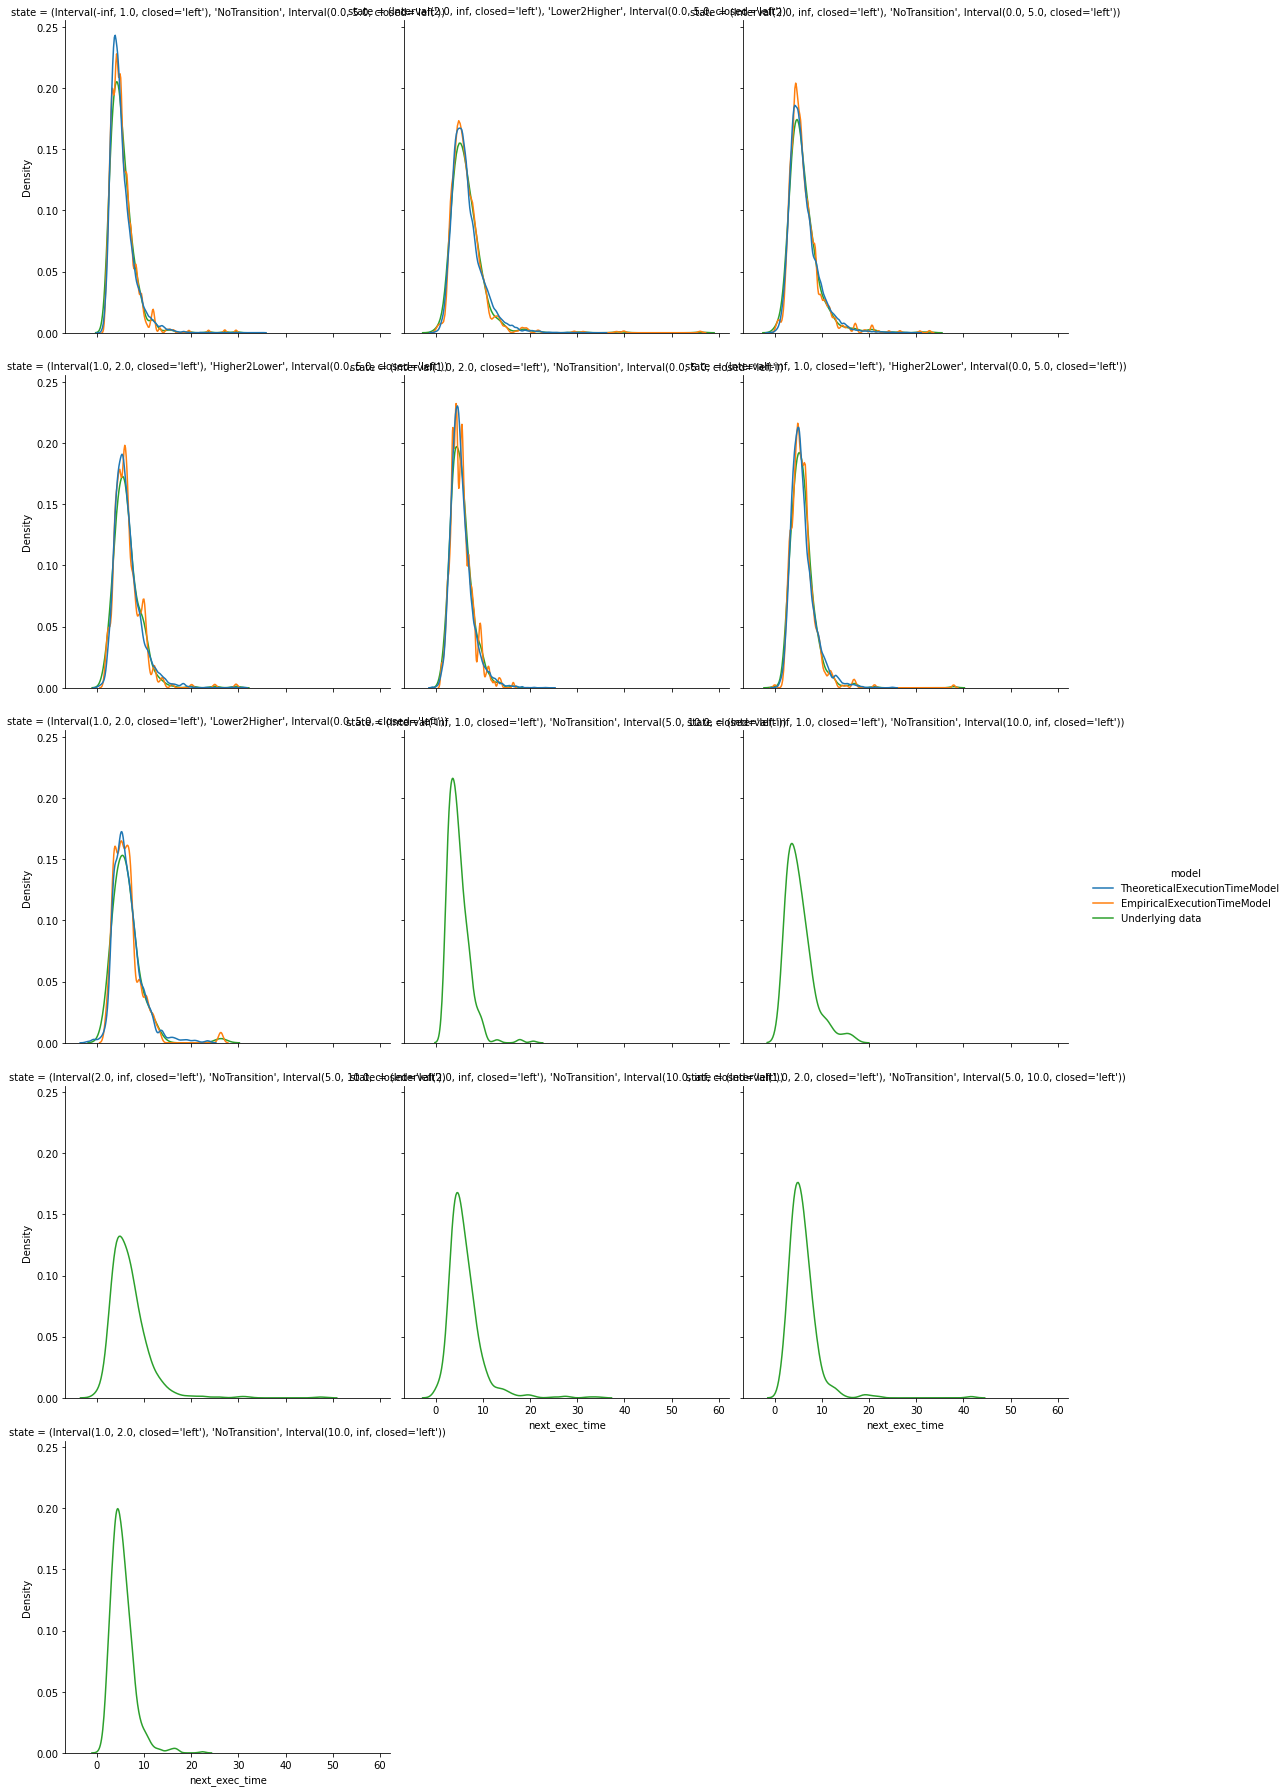

In [8]:
_df = exec_times.copy()
_df["state"] = _df[["impairment", "transition", "duration"]].apply(lambda r: tuple(r.values), axis=1)

fg = sns.displot(
    kind="kde",
    data=_df,
    col="state",
    col_wrap=3,
    x="next_exec_time",
    common_norm=False,
    # common_bins=True,
    # stat="density",
    hue="model",
    # bins=25,
)
plt.show()
del _df

# for g, df_sg in exec_times.groupby(['impairment', 'transition', 'duration']):
#     ax = sns.kdeplot(
#         # kind='kde',
#         data=df_sg,
#         x='next_exec_time',
#         hue='model',
#         # cumulative=True,
#         common_norm=False
#     )
#     ax.set_title(str(g))
#     plt.show()

In [9]:
# randomly sample participant, compare with model, repeat

samples = 500
run_ids = raw_data.run_id.unique()
rng = np.random.default_rng()

dfs = deque()

for model_cls in tqdm((EmpiricalExecutionTimeModel, TheoreticalExecutionTimeModel), desc="Models"):
    model_name = model_cls.__name__

    pbar = trange(samples)
    pbar.set_description(f"Samples for model {model_name}")
    for si in pbar:
        run = rng.choice(run_ids)
        df = raw_data[raw_data.run_id == run]

        # df holds data for a single participant
        delays = df.delay.values
        neuro = df.neuroticism.values[0]
        exec_times = np.concatenate((df.exec_time, np.array([np.nan])))

        model = model_cls(data=data, neuroticism=neuro, transition_fade_distance=fade_distance)
        trace = util.gen_model_trace(delays, model)

        trace["exec_time_rel"] = trace.exec_time / exec_times
        trace["base_exec_times"] = exec_times
        trace["run_id"] = run
        trace["sample"] = si
        trace["model"] = model_name
        dfs.append(trace)

trace_data = pd.concat(dfs, ignore_index=True)

Models:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

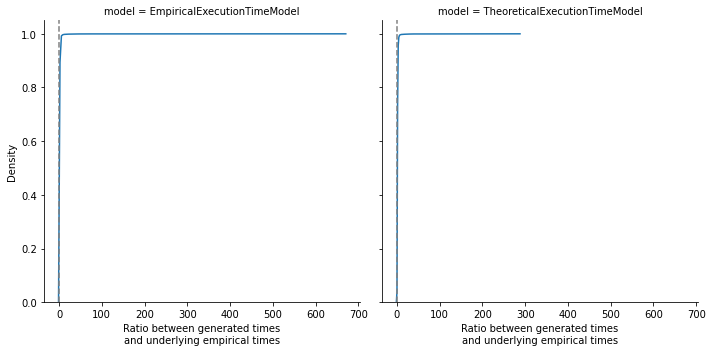

In [10]:
fg = sns.displot(
    kind="kde",
    data=trace_data,
    x="exec_time_rel",
    common_norm=False,
    col="model",
    cumulative=True
)
fg.set_xlabels("Ratio between generated times\nand underlying empirical times")
fg.refline(x=1)
plt.show()

In [11]:
trace_data.groupby("model")["exec_time_rel"].describe(percentiles=[0.1, 0.25, 0.50, 0.75, 0.99, 0.999])

,count,mean,std,min,10%,25%,50%,75%,99%,99.9%,max
model,,,,,,,,,,,
EmpiricalExecutionTimeModel,84000.0,1.305667,3.724984,0.004426,0.466962,0.676338,1.000000,1.489208,4.883161,25.468898,669.693878
TheoreticalExecutionTimeModel,84000.0,1.306296,3.251526,-0.362258,0.460574,0.670562,1.001345,1.503862,4.791884,25.212939,286.925350


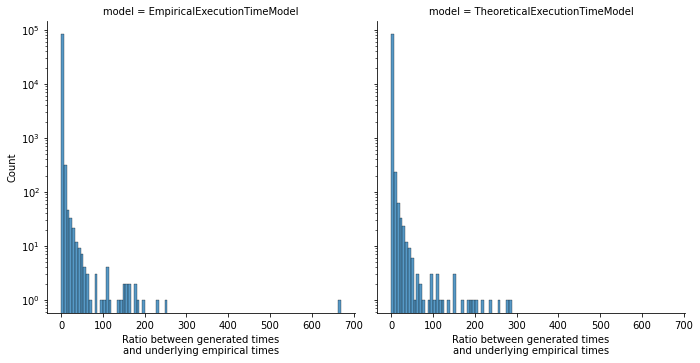

In [12]:
fg = sns.displot(
    kind="hist",
    data=trace_data,
    x="exec_time_rel",
    # common_norm=False,
    col="model",
    bins=100,
    # cumulative=True
)
fg.set_xlabels("Ratio between generated times\nand underlying empirical times")
fg.set(yscale='log')
plt.show()

In [13]:
trace_data

,model neuroticism,model neuroticism (binned),latest impairment,latest transition,current duration,current duration (binned),exec_time,delay,exec_time_rel,base_exec_times,run_id,sample,model
0,0.406,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,0,"[0.0, 5.0)",3.851000,NaN,0.777980,4.950,134614,0,EmpiricalExecutionTimeModel
1,0.406,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,1,"[0.0, 5.0)",6.735000,3.0,1.675373,4.020,134614,0,EmpiricalExecutionTimeModel
2,0.406,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,2,"[0.0, 5.0)",6.735000,3.0,1.281880,5.254,134614,0,EmpiricalExecutionTimeModel
3,0.406,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,3,"[0.0, 5.0)",2.809000,3.0,0.593242,4.735,134614,0,EmpiricalExecutionTimeModel
4,0.406,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,4,"[0.0, 5.0)",8.294000,3.0,1.301428,6.373,134614,0,EmpiricalExecutionTimeModel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168995,0.438,"[0.3333333333333333, 0.6666666666666666)","[-inf, 1.0)",NoTransition,4,"[0.0, 5.0)",3.706322,0.0,0.572847,6.470,135670,499,TheoreticalExecutionTimeModel
168996,0.438,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,1,"[0.0, 5.0)",3.973754,2.7,0.840473,4.728,135670,499,TheoreticalExecutionTimeModel
168997,0.438,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,2,"[0.0, 5.0)",4.490822,2.7,0.912212,4.923,135670,499,TheoreticalExecutionTimeModel
168998,0.438,"[0.3333333333333333, 0.6666666666666666)","[2.0, inf)",Lower2Higher,3,"[0.0, 5.0)",4.786588,2.7,1.024088,4.674,135670,499,TheoreticalExecutionTimeModel


In [14]:
params = ["latest impairment", "latest transition", "current duration (binned)"]


trace_data.groupby(["latest impairment", "latest transition",
                    "current duration (binned)", "model"])["exec_time_rel"]\
    .describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9, 0.999])\
    .sort_values("max", ascending=False)

count  \
latest impairment latest transition current duration (binned) model                                    
[2.0, inf)        NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    23960.0   
                                                              TheoreticalExecutionTimeModel  23957.0   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                TheoreticalExecutionTimeModel   7323.0   
                                                              EmpiricalExecutionTimeModel     7291.0   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                TheoreticalExecutionTimeModel  11823.0   
                                                              EmpiricalExecutionTimeModel    11825.0   
[-inf, 1.0)       NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    16962.0   
                                                              TheoreticalExecutionTimeModel  16951.0   
[1.0, 2.0)        NoTransition      [0.0, 5.0)                TheoreticalExecutionTimeModel  18000.0   
                  Higher2Lower      [0.0, 5.0)                EmpiricalExecutionTimeModel     4614.0   
                  NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    18000.0   
                  Lower2Higher      [0.0, 5.0)                EmpiricalExecutionTimeModel     1348.0   
                                                              TheoreticalExecutionTimeModel   1340.0   
                  Higher2Lower      [0.0, 5.0)                TheoreticalExecutionTimeModel   4606.0   

                                                                                                 mean  \
latest impairment latest transition current duration (binned) model                                     
[2.0, inf)        NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    1.454880   
                                                              TheoreticalExecutionTimeModel  1.459433   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                TheoreticalExecutionTimeModel  1.358407   
                                                              EmpiricalExecutionTimeModel    1.472094   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                TheoreticalExecutionTimeModel  1.315083   
                                                              EmpiricalExecutionTimeModel    1.284843   
[-inf, 1.0)       NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    1.226859   
                                                              TheoreticalExecutionTimeModel  1.234226   
[1.0, 2.0)        NoTransition      [0.0, 5.0)                TheoreticalExecutionTimeModel  1.180345   
                  Higher2Lower      [0.0, 5.0)                EmpiricalExecutionTimeModel    1.171767   
                  NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    1.168567   
                  Lower2Higher      [0.0, 5.0)                EmpiricalExecutionTimeModel    1.216647   
                                                              TheoreticalExecutionTimeModel  1.213226   
                  Higher2Lower      [0.0, 5.0)                TheoreticalExecutionTimeModel  1.188911   

                                                                                                  std  \
latest impairment latest transition current duration (binned) model                                     
[2.0, inf)        NoTransition      [0.0, 5.0)                EmpiricalExecutionTimeModel    5.483122   
                                                              TheoreticalExecutionTimeModel  4.683495   
[-inf, 1.0)       Higher2Lower      [0.0, 5.0)                TheoreticalExecutionTimeModel  6.287580   
                                                              EmpiricalExecutionTimeModel    7.294046   
[2.0, inf)        Lower2Higher      [0.0, 5.0)                TheoreticalExecutionTimeModel  1.965611   
              

In [15]:
# neuro = raw_data.neuroticism.unique()
#
# for n in neuro:
#     lt = n - 0.15
#     ut = n + 0.15
#     print(neuro[(neuro > lt) & (neuro < ut)])

data.groupby("neuroticism")["run_id"].apply(lambda x: np.unique(x).size)

neuroticism
[-inf, 0.3333333333333333)                   8
[0.3333333333333333, 0.6666666666666666)    19
[0.6666666666666666, inf)                   13
Name: run_id, dtype: int64